## Como usar o pacote `basedosdados` em Python para análise de dados públicos


### 0. Explore nosso catálogo de bases!

Através do [nosso site](https://basedosdados.org/) é possível acessar informações sobre +930 bases de dados públicas nacionais e internacionais de diversas organizações e temas.

Ao buscar por algum tema ou base, você pode descobrir quais dados já tratamos e disponibilizamos no nosso _datalake_ público pelo símbolo 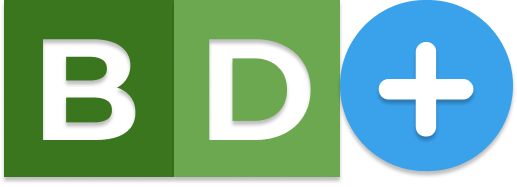

Neste webinar iremos utilizar o [pacote da `basedosdados` (Python)](https://github.com/basedosdados/mais) para mostrar como acessar as bases disponíveis na 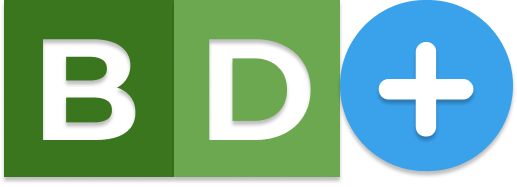

- Outros recursos: [Tutorial escrito "Base de Dados Python 101"](https://dev.to/basedosdados/base-dos-dados-python-101-44lc)

### 1. Instale o pacote

In [ ]:
# Todos os pacotes usados neste exemplo estão listados no requirements.txt, você pode instalar com:
# ! pip install -r requirements.txt
# Ou somente instalar nosso pacote, caso já tenha os demais listados:
# ! pip install basedosdados

In [ ]:
import basedosdados as bd

### 2. Explore os dados disponíveis na BD+

Uma vez importado o pacote, vamos explorar os módulos de requisição de dados do nosso *datalake* público. Você pode ler em detalhes sobre todas as funcionalidades do pacote na nossa documentação: https://basedosdados.github.io/mais/reference_api_py/

* Listar datasets disponíveis:

In [ ]:
# ?bd.list_datasets
bd.list_datasets(with_description=True)

* Listar tabelas disponíveis num determinado dataset:

In [ ]:
# ?bd.list_dataset_tables
bd.list_dataset_tables(dataset_id="br_inpe_prodes", with_description=True)

* Obter metadados das colunas de ums tabela:

In [ ]:
# ?bd.get_table_columns
bd.get_table_columns(
    dataset_id="br_inpe_prodes",
    table_id="desmatamento_municipios"
)

#### Configurando sua conta no Google Cloud

As funções que necessitam fazer consultas diretas aos dados no *datalake* necessitam de que você crie um projeto para autenticação no Google Cloud. O passo a passo de como fazer isso vai aparecerr direto no erro na sua tela, mas você também pode ver na nossa [documentação](https://basedosdados.github.io/mais/access_data_local/#criando-um-projeto-no-google-cloud).

_Não é necessário passar nenhuma informação de pagamento, você só precisa criar um projeto que será cobrado caso ultrapasse sua cota - são 1TB de processamento por mês, nem a gente consegue ultrapassar esse limite!_

In [ ]:
# Vamos obter um erro neste comando: não é passado um billing_project_id!
# Na mensagem de erro vão aparecer as instruções de como criar um projeto no GCloud 
# e achar seu project_id para ser usado nas consultas aos dados

bd.read_table(dataset_id="br_inpe_prodes", table_id="desmatamento_municipios", limit=100)

Uma vez configurado o projeto no Google Cloud, podemos rodar a consulta passando o seu `project_id` no parâmetro `billing_project_id`

In [ ]:
bd.read_table(
    dataset_id="br_inpe_prodes", 
    table_id="desmatamento_municipios", 
    limit=10,
    billing_project_id="gcp_escoladedados")

* Calcular tamanho da tabela:

In [ ]:
bd.get_table_size(
    dataset_id="br_inpe_prodes",
    table_id="desmatamento_municipios",
    billing_project_id="gcp_escoladedados"
)

* Carregar a tabela no ambiente como um `Dataframe`:

In [ ]:
df_prodes = bd.read_table(
    dataset_id="br_inpe_prodes", 
    table_id="desmatamento_municipios", 
    billing_project_id="gcp_escoladedados")

In [ ]:
df_prodes.info()

In [ ]:
df_prodes.head()

* Consertar tipos das colunas:

In [ ]:
cols_float = ["area", "desmatado", "incremento", "floresta", "nuvem", "nao_observado", "nao_floresta", "hidrografia"]
df_prodes[cols_float] = df_prodes[cols_float].astype(float)

* Verificar abrangência temporal:

In [ ]:
df_prodes["ano"].unique()

* **Questão: Quais foram os municípios com maior incremento área desmatada em 2018-2019?**

In [ ]:
(df_prodes[df_prodes["ano"] == 2019]
 .sort_values(by="incremento", ascending=False)
 .head(10))

**Mas afinal, quais são esses municípios?**

### Explorando a tabela de Diretórios Brasileiros 

Reunimos numa base única construída pela Base dos Dados os códigos institucionais e informações de entidades brasileiras, como municípios. Você pode saber mais sobre a base aqui: https://basedosdados.org/dataset/br-bd-diretorios-brasil

_Por que construímos essa base? Para resolver os seguintes problemas:_

- Não existe um identificador único para municípios entre instituições brasileiras.
- IDs e nomes mudam tem typos entre anos e entres instituições.
- Municípios são criados ao longo do tempo, ganhando IDs novos.

In [ ]:
df_diretorios = bd.read_table(
    dataset_id="br_bd_diretorios_brasil", 
    table_id="municipio", 
    billing_project_id="gcp_escoladedados")

In [ ]:
df_diretorios.info()

In [ ]:
df_diretorios.head()

In [ ]:
df_prodes = df_prodes.merge(df_diretorios[["id_municipio", "municipio", "sigla_uf"]], on="id_municipio", how="left")
df_prodes

* Criar coluna com o nome completo `Município/UF`:

In [ ]:
df_prodes["municipio_uf"] = df_prodes["municipio"] + "/" + df_prodes["sigla_uf"]

* Listar municípios com maior incremento em área desmatada em 2018-2019:

In [ ]:
(df_prodes[df_prodes["ano"] == 2019]
 .sort_values(by="incremento", ascending=False)
 .head(10))[["municipio_uf", "incremento"]]

### Analisando dados históricos de desmatamento


Agora com os dados prontos, vamos explorar algumas visualizações!

#### Qual foi o total de área desmatada ao longo dos anos?

In [ ]:
area_acumulada = df_prodes.groupby("ano")[["desmatado"]].sum().round(2)
area_acumulada.columns = ["Área total desmatada (km2)"]
area_acumulada

In [ ]:
import plotly.express as px

In [ ]:
px.bar(area_acumulada,
       y="Área total desmatada (km2)",
       text="Área total desmatada (km2)",
       title="Aumento de área total desmatada (km2) na Amazônia Legal de 2000 a 2019")

#### Quais os municípios com maior área desmatada até 2019?

In [ ]:
ranking_municipios_2019 = (
    df_prodes[df_prodes["ano"] == 2019]
    .sort_values(by="desmatado", ascending=False)
    .head(15))[["municipio_uf", "desmatado"]]

ranking_municipios_2019.columns = ["Município", "Área desmatada (km2)"]
ranking_municipios_2019

In [ ]:
px.bar(ranking_municipios_2019.sort_values(by="Área desmatada (km2)"),
       x="Área desmatada (km2)",
       y="Município",
       text="Área desmatada (km2)",
       title="Municípios com maior área desmatada (km2) na Amazônia Legal até 2019",
       orientation="h",
       height=600)

#### Qual a relação entre a produção pecuária e a área dematada nos municípios?

Que tal cruzar os dados de desmatamento com a quantidade de rebanho bonivo? Vamos puxar os dados sobre os rebanhos da [Pesquisa Pecuária Municipal (PPM)](https://basedosdados.org/dataset/br-ibge-ppm) disnponíveis também na Base dos Dados para alimentar nossa análise.

In [ ]:
# Como os dados são desde 1974 e queremos somente 2019, ao invés de carregar a base inteira iremos passar
# uma query em SQL para filtrar os dados antes de carregar no nosso ambiente
query = """
SELECT * FROM `basedosdados.br_ibge_ppm.efetivo_rebanhos`
WHERE ano = 2019;
"""

df_ppm = bd.read_sql(query, billing_project_id="gcp_escoladedados")

In [ ]:
df_ppm.info()

In [ ]:
df_ppm.head()

In [ ]:
df_ppm["tipo_rebanho"].unique()

* Filtrar rebanhos bovinos:

In [ ]:
df_ppm = df_ppm[df_ppm["tipo_rebanho"] == "Bovino"]

In [ ]:
df_ppm = df_ppm.merge(df_prodes[["ano", "id_municipio", "municipio_uf", "desmatado"]], on=["id_municipio", "ano"], how="inner")
df_ppm

In [ ]:
import numpy as np

In [ ]:
fig = px.scatter(
    df_ppm.sort_values(by="quantidade_animais", ascending=False, ignore_index=True).loc[1:],
    x="quantidade_animais", 
    y="desmatado",
    title="Área desmatada por quantidade de rebanho bovino nos municípios em 2019",
    trendline="ols"
)

# Outro jeito de redefinir titulos dos eixos...
fig.update_layout(dict(xaxis=dict(title="Quantidade de rebanho bovino"),
                       yaxis=dict(title="Área dematada (km2)")))

fig.show()

In [ ]:
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()